In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [4]:
'''
Creating an atlas
'''
deep_reload(nice)

rng = np.random.default_rng(26893751)

scale = (.5e6, 0)

nodes = [
    ('A', {'x': 0 * scale[0], 'y': 0 * scale[1], 'population': 1}),
    ('S0', {'x': .25 * scale[0], 'y': .25 * scale[1]}),
    ('S1', {'x': .5 * scale[0], 'y': .5 * scale[1]}),
    ('S2', {'x': .75 * scale[0], 'y': .75 * scale[1]}),
    ('B', {'x': 1 * scale[0], 'y': 1 * scale[1], 'population': 1}),
]

d = np.sqrt((.25 * scale[0]) ** 2 + (.25 * scale[1]) ** 2)

edges = [
    ('A', 'S0', {'distance': d}),
    ('S0', 'S1', {'distance': d}),
    ('S1', 'S2', {'distance': d}),
    ('S2', 'B', {'distance': d}),
]

atlas = nx.Graph()
atlas.add_nodes_from(nodes)
atlas.add_edges_from(edges)
atlas = nx.DiGraph(atlas)

for source, _adj in atlas._adj.items():
    for target, edge in _adj.items():

        speed = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / speed
        edge['energy'] = 500 * edge['distance']
        edge['cost'] = edge['time']

'''
Selecting places and stations
'''

places = ['A', 'B']
stations = ['S0', 'S1', 'S2']

In [5]:
'''
Creating a Vehicle
'''
deep_reload(nice)

kw = {
    'capacity': 45 * 3.6e6,
    'fields': ['time', 'distance', 'energy']
}

vehicle = nice.optimization.Vehicle(**kw)

graph = vehicle.transform(atlas, places + stations)

In [6]:
deep_reload(nice)

paths = nice.optimization.get_paths(
    graph, terminals = places, k = 25, weight = 'time',
)

 [------------>] (2/2) 100.00%, 1737.49 it/s, 0.00 s elapsed, 0.00 s remaining

In [7]:
[p['path'] for p in paths]

[['A', 'S1', 'B'],
 ['A', 'S0', 'S1', 'B'],
 ['A', 'S1', 'S2', 'B'],
 ['A', 'S0', 'S2', 'B'],
 ['A', 'S0', 'S1', 'S2', 'B'],
 ['B', 'S1', 'A'],
 ['B', 'S2', 'S0', 'A'],
 ['B', 'S1', 'S0', 'A'],
 ['B', 'S2', 'S1', 'A'],
 ['B', 'S2', 'S1', 'S0', 'A']]

In [12]:
'''
Places
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
    'friction_function': lambda x: 1,
    'remove_function': lambda x: nice.demand.within_range(x, 500, 45 * 3.6e6),
}

graph = nice.demand.demand(graph, places, **kw)

In [13]:
graph._node['A']

{'x': 0.0,
 'y': 0,
 'population': 1,
 'cost': 17210.88110149639,
 'flows': {'B': 0.5},
 'free_flow': {'B': {'time': 17210.88110149639, 'distance': 500000.0}},
 'mode_switch': {'B': 55089.668980284274}}

In [15]:
min_cost = 0

for source, node in graph._node.items():
    if source in places:
        for target, cost in node['free_flow'].items():

            min_cost += cost['time'] * node['flows'][target]

max_cost = 0

for source, node in graph._node.items():
    if source in places:
        for target, cost in node['mode_switch'].items():

            max_cost += cost * node['flows'][target]

min_cost / 3600, max_cost / 3600

(4.780800305971219, 15.302685827856743)

In [16]:
'''
Stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))
c = np.arange(0, 31, 1)

queue = nice.queue.Queue(m = m)
volumes = np.array([rho * m * size for size in c])
delays =  np.array(
    [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
)

for station in stations:

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * volumes)
    graph._node[station]['expenditures'] = c

In [31]:
'''
Adding charging information at stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))

for station in stations:

    node = graph._node[station]
    m = 1 / (energy / power)
    n = 10
    lower_bound = 10
    upper_bound = 10
    c = list(range(lower_bound, upper_bound + 1))
    queue = nice.queue.Queue(m = m, rho = rho, c = c)
    
    volumes = np.array([rho * m * size for size in c])
    delays =  np.array(
        [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
    )

    counts = np.array([c for c in c])
    expenditure = np.array([c - n for c in c])
    expenditure[expenditure > 0] = expenditure[expenditure > 0] * 1.25

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * volumes)
    graph._node[station]['counts'] = counts
    graph._node[station]['expenditures'] = expenditure

    # print(graph._node[station]['expenditures'])

In [32]:
'''
Adding classes
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['cost'] = edge['time']
        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

In [33]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Objects Built: 0.000946044921875
Sets Built: 0.0008413791656494141
Parameters Built: 0.0012137889862060547
Variables Built: 0.0011107921600341797
Constraints Built: 0.0013167858123779297
Expenditure Built: 5.340576171875e-05
Objective Built: 0.00016736984252929688


In [36]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
        # '_name': 'appsi_highs',
        'time_limit': 10 * 6,
        # 'sec': 10,
        # 'ratio': .000001,
    },
}

network.model.scale = 1e4 / 3600
network.model.expenditure = 0
network.model.expenditure_cost = 0
network.solve(**kw)
solution = network.solution
solution = nice.optimization.solution_atlas(
    network.solution, atlas, fields = ['volume']
)

Problem Solved: 0.016292333602905273
Results Collected: 0.0003783702850341797


In [37]:
solution._node['S1']

{'x': 250000.0,
 'y': 0.0,
 'cost': 8605.440550748195,
 'power': 80000.0,
 'volumes': array([[0.        , 0.00507937, 0.00514286, 0.00520301, 0.00526316,
         0.00532331, 0.00538346, 0.00544361, 0.00550376, 0.00556391,
         0.00562406, 0.00568421, 0.00574436, 0.00580451, 0.00586466,
         0.00592481, 0.00598496, 0.00604511, 0.00610526, 0.00616541,
         0.00622556, 0.00628571]]),
 'delays': array([[0.00000000e+00, 1.36068792e-02, 1.74322711e-02, 2.20998282e-02,
         2.81038129e-02, 3.58745228e-02, 4.60047977e-02, 5.93238113e-02,
         7.70114251e-02, 1.00780087e-01, 1.33172913e-01, 1.78069244e-01,
         2.41577049e-01, 3.33684386e-01, 4.71493353e-01, 6.86005793e-01,
         1.03764614e+00, 1.65595865e+00, 2.85758007e+00, 5.58124050e+00,
         1.36515654e+01, 5.72194095e+01]]),
 'expenditures': array([0]),
 'counts': array([10]),
 'size': 1,
 'usage': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0

In [28]:
import pyomo.environ as pe

pe.value(network.model.objective) / pe.value(network.model.scale) / 3600

4.780980116817622

In [29]:
num = sum(
    [n.get('mode_switch', 0) for n in solution._node.values()]
)

den = sum(
    [n.get('total', 0) for n in solution._node.values()]
)

ratio = np.nan_to_num(num / den)

scale, ratio

((500000.0, 0), 0.0)

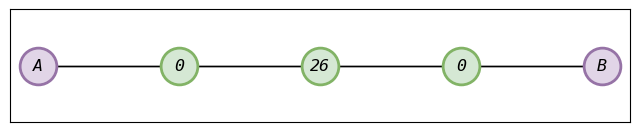

In [24]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600
    node['optimal_ports'] = node.get('counts', 0)
    node['label'] = source
    # node['optimal_ports'] = node.get('port_count', 0)

kw = {
    'nodes': {
        'selection': stations,
        'plot': {
            's': 700,
            'lw': 2,
            'zorder': 2,
            'ec': '#82B366',
            'fc': '#D5E8D4',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': places,
        'plot': {
            's': 700,
            'zorder': 2,
            'lw': 2,
            'ec': '#9673A6',
            'fc': '#E1D5E7',
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'edges': {
        'plot': {
            'lw': 1,
            'color': 'k',
            'alpha': 1,
            'zorder': 0,
        },
    },
}
    
_ = nice.plot.plot_graph(atlas, ax = ax, **kw)

kw = {
    'selection': stations,
    'plot': {
        'horizontalalignment': 'center',
        'verticalalignment': 'center',
        'fontstyle': 'italic',
        'fontweight': 'roman',
        'fontfamily': 'monospace',
        'fontsize': 'large',
    },
    'field': 'selection',
}

_ = nice.plot.plot_labels(solution, ax = ax, **kw)

kw = {
    'selection': places,
    'plot': {
        'horizontalalignment': 'center',
        'verticalalignment': 'center',
        'fontstyle': 'italic',
        'fontweight': 'roman',
        'fontfamily': 'monospace',
        'fontsize': 'large',
    },
    'field': 'label',
}

_ = nice.plot.plot_labels(solution, ax = ax, **kw)

kw = {
    'facecolor': 'white',
    'ylim': (-50e3, 50e3),
    'xticks': [],
    'yticks': [],
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

# ax.grid(**kw)

ax.set_aspect('equal')

In [95]:
scales = np.arange(1e0, 1e3, 1e1) / 3600
costs = []
ratios = []

k = 0

for scale in nice.progress_bar.ProgressBar(scales):

    kw = {
        'verbose': False,
        'solver': {
            '_name': 'appsi_highs',
            'time_limit': 10 * 6,
        },
    }
    
    network.model.scale = scale
    network.solve(**kw)
    solution = network.solution

    num = sum(
        [n.get('direct', 0) for n in solution._node.values()]
    )
    
    den = sum(
        [n.get('total', 0) for n in solution._node.values()]
    )
    
    ratio = np.nan_to_num(num / den)

    ratios.append(ratio)
    costs.append(network.objective_value)

    k += 1

 [---------->] (100/100) 100.00%, 1.76 it/s, 57.41 s elapsed, 0.00 s remaining

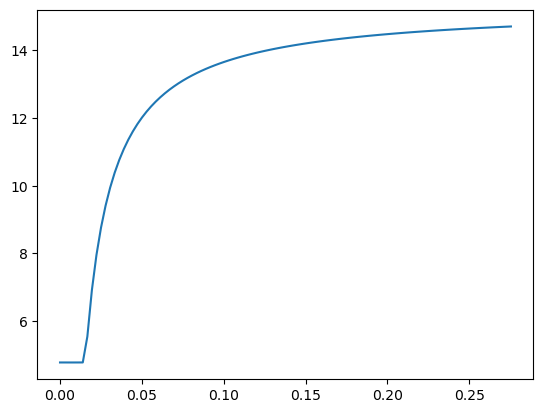

In [96]:
plt.plot(scales, costs / scales / 3600)